In [1]:
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pymc_marketing import clv
os.chdir("../")
from src.data import (
    getDataset,
    ProcessData
)
from src.config import RawFeatures
from src.models import BetaGeoModel
from src.utils import g

In [2]:
import arviz as az
from arviz.labels import MapLabeller

In [3]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina" # nice looking plots

In [4]:
dt_format_ = '%d/%m/%Y %H:%M'
_dt_format = '%Y-%m-%d %H:%M'
df_transaction = getDataset()
df_transaction[RawFeatures.TRANSACTION_DATE] = df_transaction[RawFeatures.TRANSACTION_DATE].apply(
                                                    lambda x: dt.datetime.strptime(x, dt_format_).strftime(_dt_format) if x==x else x)

In [5]:
df_transaction.head()


,Customer ID,InvoiceDate,Price,Quantity
0,13085.0,2009-12-01 07:45,6.95,12.0
1,13085.0,2009-12-01 07:45,6.75,12.0
2,13085.0,2009-12-01 07:45,6.75,12.0
3,13085.0,2009-12-01 07:45,2.10,48.0
4,13085.0,2009-12-01 07:45,1.25,24.0


In [6]:
# pd.to_datetime(
#    df_transaction[RawFeatures.TRANSACTION_DATE].dropna().apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M')),
# ).dt.date

In [7]:
data_inst = ProcessData(df_transaction, 'D', '2011-06-30')
data_summary = data_inst.model_data()
data_summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12745.0,1.0,88.0,574.0,266.930000
12747.0,25.0,730.0,732.0,355.835600
12748.0,202.0,735.0,735.0,279.101436
12749.0,6.0,518.0,521.0,1010.743333


In [18]:
data_summary["T"].max()

738.0

In [19]:
data_summary["recency"].max()

738.0

In [8]:
data_summary.describe().iloc[[1, 2, 3, 5, 7], :]

,frequency,recency,T,monetary_value
mean,6.490052,386.782461,526.574346,422.646958
min,1.000000,1.000000,9.000000,3.900000
50%,3.000000,389.000000,592.000000,300.305000
max,202.000000,738.000000,738.000000,168469.600000


# Modeling


In [9]:
bgm = BetaGeoModel(data_summary, 7)
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.113,0.012,0.091,0.136,0.000,0.000,1920.0,1907.0,1.0
b,1.276,0.197,0.910,1.646,0.004,0.003,1977.0,1886.0,1.0
alpha,95.905,2.891,90.536,101.387,0.073,0.051,1586.0,1845.0,1.0
r,1.435,0.038,1.361,1.501,0.001,0.001,1562.0,2052.0,1.0


# Plots

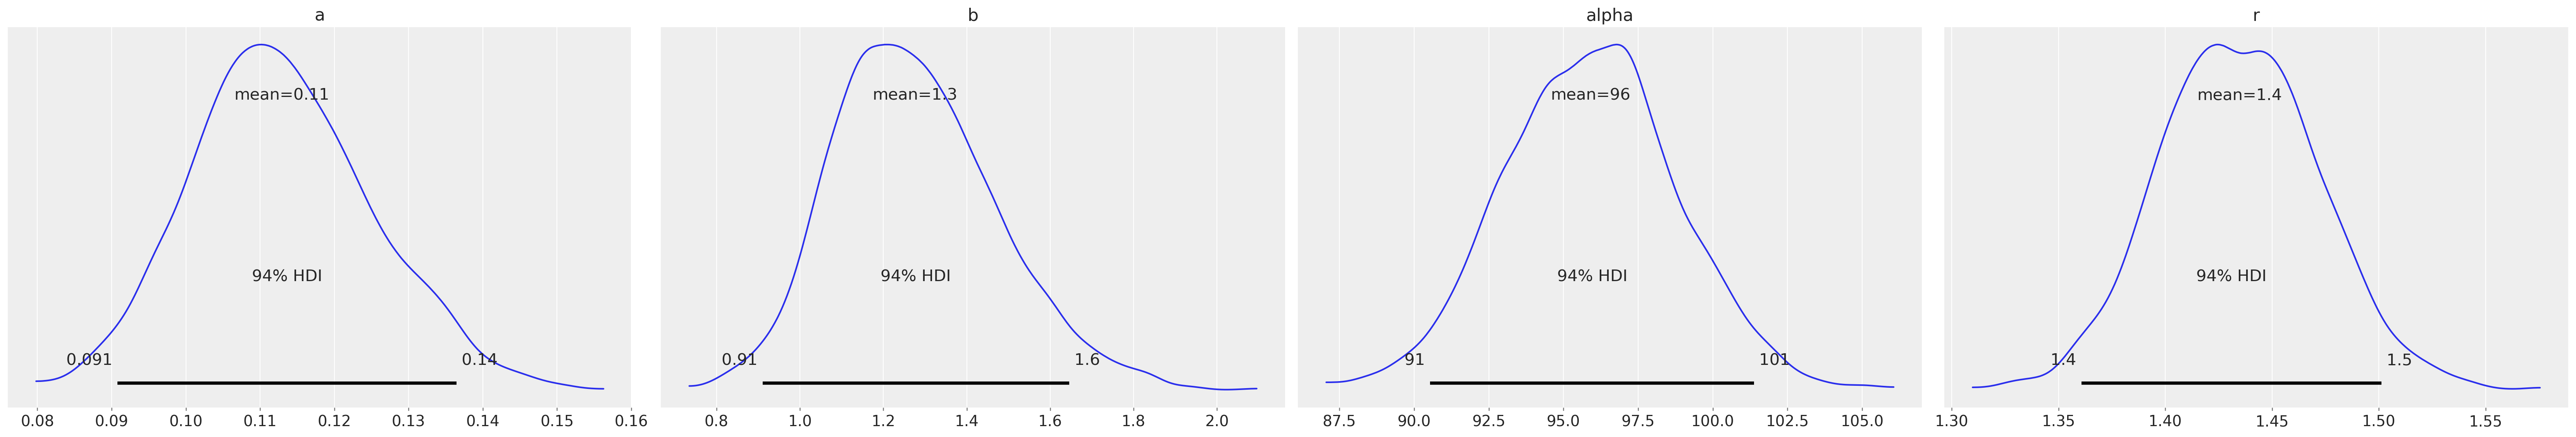

In [10]:
az.plot_posterior(bgm.fit_result);

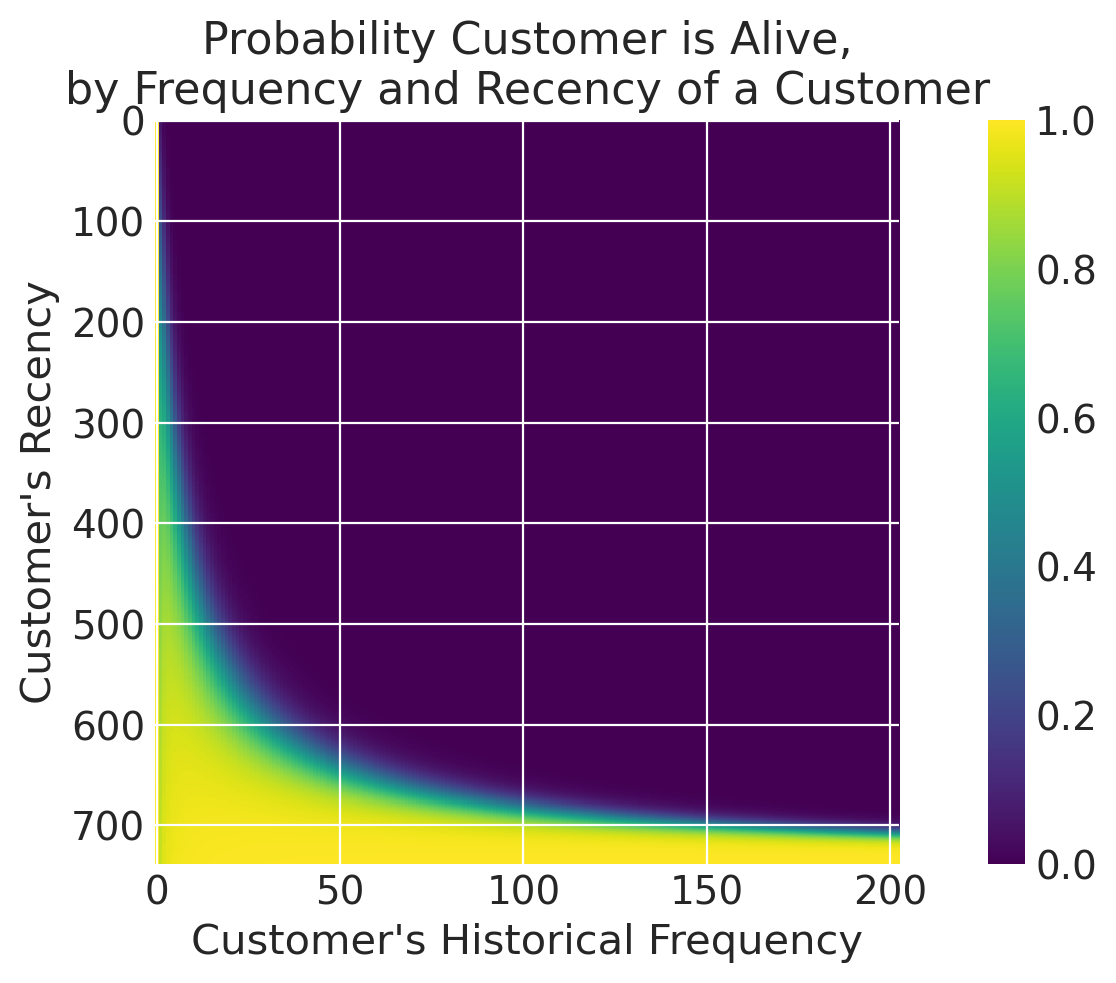

In [22]:
clv.plot_probability_alive_matrix(bgm);

In [32]:
customer_id = 12748.0

In [33]:
customer_history = pd.DataFrame(dict(
                    Customer_ID=np.full(10, customer_id, dtype="int"),
                    frequency=np.full(10, data_summary.loc[customer_id]["frequency"], dtype="int"),
                    recency=np.full(10, data_summary.loc[customer_id]["recency"]),
                    T=(np.arange(-1, 9) + data_summary.loc[customer_id]["T"]).astype("int"),
                ))
customer_history

,Customer_ID,frequency,recency,T
0,12748,202,735.0,734
1,12748,202,735.0,735
2,12748,202,735.0,736
3,12748,202,735.0,737
4,12748,202,735.0,738
5,12748,202,735.0,739
6,12748,202,735.0,740
7,12748,202,735.0,741
8,12748,202,735.0,742
9,12748,202,735.0,743


In [34]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_history["Customer_ID"],
    frequency=customer_history["frequency"],
    recency=customer_history["recency"],
    T=customer_history["T"],
)

az.plot_hdi(customer_history["T"], p_alive, color="C0")
plt.plot(customer_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title(f"Probability Customer {customer_id} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

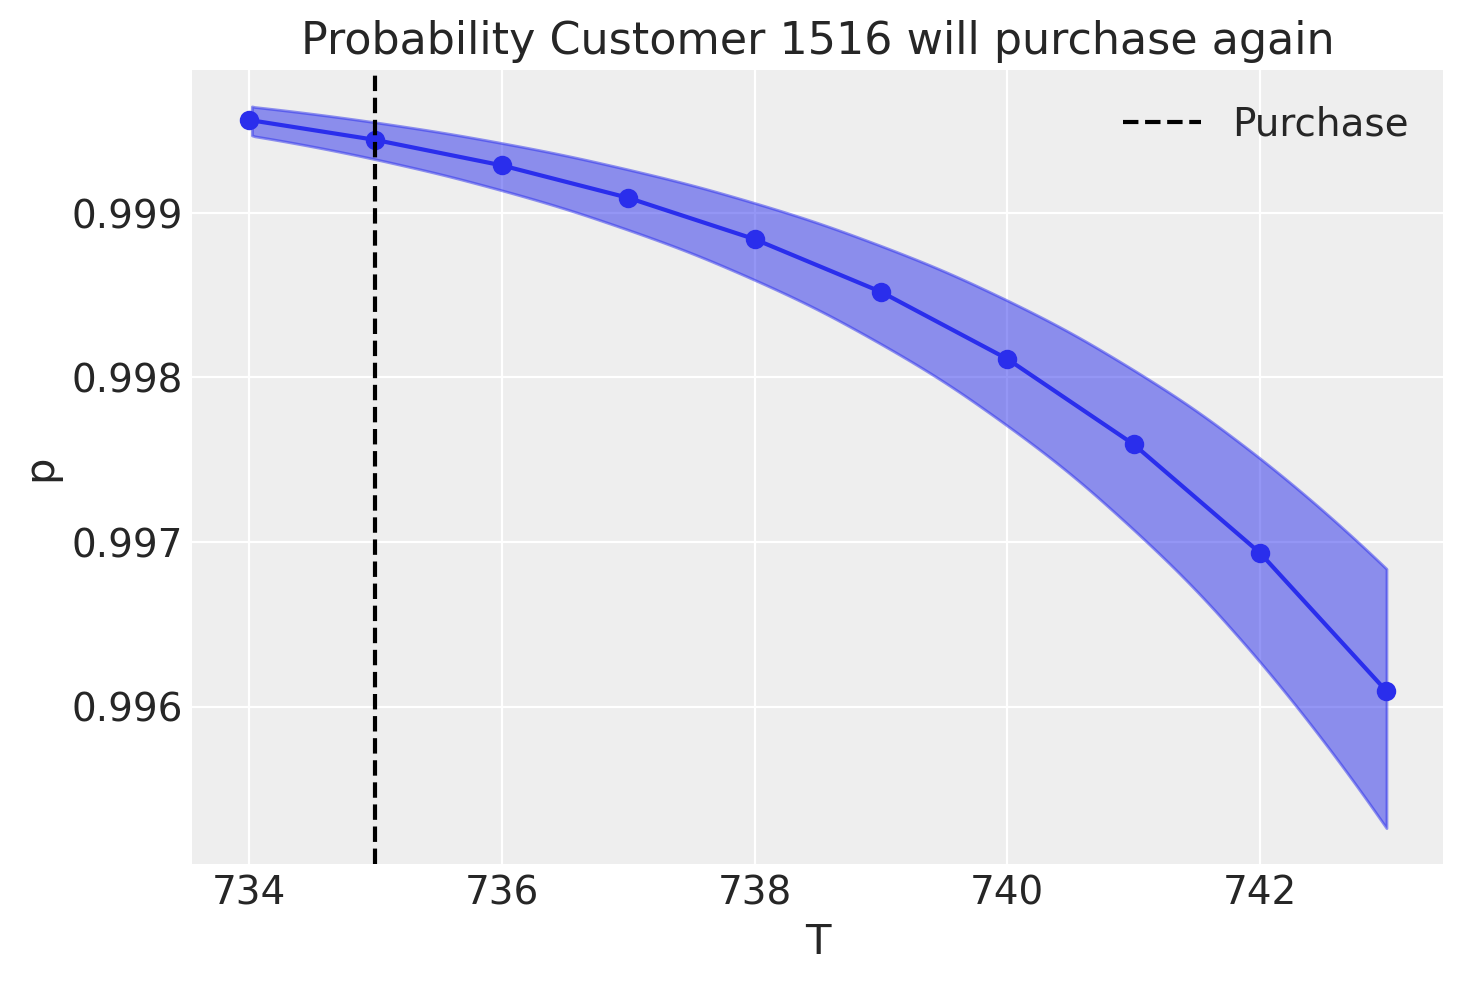

In [35]:
bgm.alive_probability(customer_id)

In [36]:
customer_history_what_if = customer_history.copy()

In [37]:
customer_history_what_if["frequency"].iloc[-3:] += 1
customer_history_what_if["recency"].iloc[-3:] = customer_history_what_if["T"].iloc[-3] - 0.5
customer_history_what_if

,Customer_ID,frequency,recency,T
0,12748,202,735.0,734
1,12748,202,735.0,735
2,12748,202,735.0,736
3,12748,202,735.0,737
4,12748,202,735.0,738
5,12748,202,735.0,739
6,12748,202,735.0,740
7,12748,203,740.5,741
8,12748,203,740.5,742
9,12748,203,740.5,743
